# Identifying Fraudulent Activities

## Step 1: Import Libraries and Data
First of all, load in our libraries and data.

In [1]:
import pandas as pd
import numpy as np
from datetime import time
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
%matplotlib inline

data = pd.read_csv('Data/train.csv') # training data set
test = pd.read_csv('Data/test.csv')  # testing date set
county = pd.read_csv('Data/countries.csv') # country encoding information

In [3]:
data.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,309557,2015-01-01 00:00:43,2015-01-01 00:00:44,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of
1,124539,2015-01-01 00:00:44,2015-01-01 00:00:45,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of
2,161246,2015-01-01 00:00:45,2015-01-01 00:00:46,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of
3,356414,2015-01-01 00:00:46,2015-01-01 00:00:47,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of
4,338656,2015-01-01 00:00:47,2015-01-01 00:00:48,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of


In [4]:
test.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,105643,2015-06-16 03:16:51,2015-08-05 11:07:00,31,WPMJAGOECDQUW,SEO,IE,M,26,2.278424e+08,0,United States
1,335148,2015-06-17 15:52:29,2015-08-05 11:08:15,15,YJTJVFXRAXKEF,Ads,Safari,M,23,3.180737e+09,0,Mexico
2,107216,2015-07-11 16:37:44,2015-08-05 11:08:15,33,DWJEHIJRXGSNR,Direct,FireFox,M,19,1.493759e+09,0,Norway
3,333106,2015-06-23 06:21:39,2015-08-05 11:10:37,31,UASFNUFBZUHFI,Ads,Safari,F,47,1.382136e+09,0,Germany
4,59781,2015-06-14 20:05:45,2015-08-05 11:13:41,23,FZGBBUXLMXQDQ,SEO,Chrome,M,34,1.387652e+09,0,Finland


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105778 entries, 0 to 105777
Data columns (total 12 columns):
user_id           105778 non-null int64
signup_time       105778 non-null object
purchase_time     105778 non-null object
purchase_value    105778 non-null int64
device_id         105778 non-null object
source            105778 non-null object
browser           105778 non-null object
sex               105778 non-null object
age               105778 non-null int64
ip_address        105778 non-null float64
class             105778 non-null int64
country           90440 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 9.7+ MB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45334 entries, 0 to 45333
Data columns (total 12 columns):
user_id           45334 non-null int64
signup_time       45334 non-null object
purchase_time     45334 non-null object
purchase_value    45334 non-null int64
device_id         45334 non-null object
source            45334 non-null object
browser           45334 non-null object
sex               45334 non-null object
age               45334 non-null int64
ip_address        45334 non-null float64
class             45334 non-null int64
country           38706 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 4.2+ MB


# Step 2: Learn something about data

Calculate contribution of the testing data in the entire (training + testing data).

In [7]:
print(len(test)/(len(test)+len(data))*100,' %')

30.000264704325268  %


We count the number of frauds in the overall training and testing data samples.

In [8]:
print('Frauds in training sample:\n', len(data[data['class']==1])/len(data)*100, ' %')
print('Frauds in test sample:\n', len(test[test['class']==1])/len(test)*100, ' %')

Frauds in training sample:
 11.417307946832045  %
Frauds in test sample:
 4.574932721577624  %


In [9]:
print('Train columns with null values:\n', data.isnull().sum())
print("-"*10)
print('Test/Validation columns with null values:\n', test.isnull().sum())
print("-"*10)

Train columns with null values:
 user_id               0
signup_time           0
purchase_time         0
purchase_value        0
device_id             0
source                0
browser               0
sex                   0
age                   0
ip_address            0
class                 0
country           15338
dtype: int64
----------
Test/Validation columns with null values:
 user_id              0
signup_time          0
purchase_time        0
purchase_value       0
device_id            0
source               0
browser              0
sex                  0
age                  0
ip_address           0
class                0
country           6628
dtype: int64
----------


We create 2 additional columns in training and test data set to calculate absolute time differences for signup and purchase times, we choose data['signup_time'][0] as zero-time.

In [10]:
data['diff1'] = (pd.to_datetime(data['signup_time']) - pd.to_datetime(data['signup_time'][0])).astype('timedelta64[h]')
data['diff2'] = (pd.to_datetime(data['purchase_time']) - pd.to_datetime(data['signup_time'][0])).astype('timedelta64[h]')
test['diff1'] = (pd.to_datetime(test['signup_time']) - pd.to_datetime(data['signup_time'][0])).astype('timedelta64[h]')
test['diff2'] = (pd.to_datetime(test['purchase_time']) - pd.to_datetime(data['signup_time'][0])).astype('timedelta64[h]')

Text(0.5,1,'test_diff2')

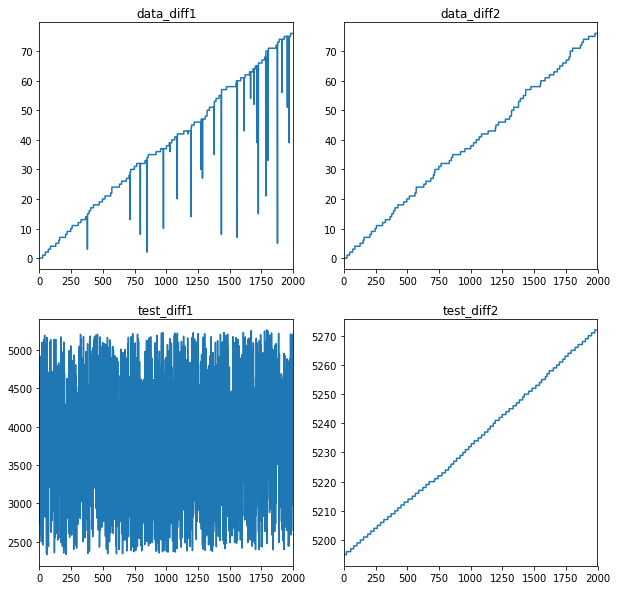

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
data['diff1'][0:2000].plot(ax=axes[0,0]); axes[0,0].set_title('data_diff1')
data['diff2'][0:2000].plot(ax=axes[0,1]); axes[0,1].set_title('data_diff2')
test['diff1'][0:2000].plot(ax=axes[1,0]); axes[1,0].set_title('test_diff1')
test['diff2'][0:2000].plot(ax=axes[1,1]); axes[1,1].set_title('test_diff2')

#### It is now clear how the data is organized into training and test data. It is sorted according to purchase time and simply first 70% of data is put into training set, while the remaining 30% constitutes test set.

# Step 3: Prepare our data for analysis

We merge columns **signup_time** i **purchase_time** into single column which represents their difference, i.e. time between the signup on the site and first transaction by the user. We denote this column with **Dt** and represent it in hours.

In [12]:
data['Dt'] = (pd.to_datetime(data['purchase_time']) - pd.to_datetime(data['signup_time'])).astype('timedelta64[h]')
test['Dt'] = (pd.to_datetime(test['purchase_time']) - pd.to_datetime(test['signup_time'])).astype('timedelta64[h]')

We won't drop rows cointaing unknown country, but introduce new category for country, simply called <b>"Unknown"</b>

In [13]:
data = data.fillna({"country": "Unknown"})
test = test.fillna({"country": "Unknown"})

In [14]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,diff1,diff2,Dt
0,309557,2015-01-01 00:00:43,2015-01-01 00:00:44,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,0.0,0.0,0.0
1,124539,2015-01-01 00:00:44,2015-01-01 00:00:45,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,0.0,0.0,0.0
2,161246,2015-01-01 00:00:45,2015-01-01 00:00:46,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,0.0,0.0,0.0
3,356414,2015-01-01 00:00:46,2015-01-01 00:00:47,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,0.0,0.0,0.0
4,338656,2015-01-01 00:00:47,2015-01-01 00:00:48,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,Korea Republic of,0.0,0.0,0.0


Let's encode country names.

In [15]:
my_dict = {}
count = -1
f =  open("Data/countries.csv", 'r')
for line in f:
    if count>-1:
        key, values = line.rstrip(), count
        my_dict[key] = values
    count = count + 1

In [16]:
cleanup_nums = {"country": my_dict}
data.replace(cleanup_nums, inplace=True)

In [17]:
data.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,diff1,diff2,Dt
0,309557,2015-01-01 00:00:43,2015-01-01 00:00:44,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,13,0.0,0.0,0.0
1,124539,2015-01-01 00:00:44,2015-01-01 00:00:45,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,13,0.0,0.0,0.0
2,161246,2015-01-01 00:00:45,2015-01-01 00:00:46,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,13,0.0,0.0,0.0
3,356414,2015-01-01 00:00:46,2015-01-01 00:00:47,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,13,0.0,0.0,0.0
4,338656,2015-01-01 00:00:47,2015-01-01 00:00:48,14,BBPACGBUVJUXF,Ads,Chrome,F,38,2.001426e+09,1,13,0.0,0.0,0.0


In [18]:
data['source'].value_counts()

SEO       42438
Ads       41879
Direct    21461
Name: source, dtype: int64

In [19]:
data['browser'].value_counts()

Chrome     43149
IE         25623
FireFox    17231
Safari     17196
Opera       2579
Name: browser, dtype: int64

In [20]:
source_dict = {'SEO' : '0','Ads' : '1', 'Direct' : '2'}
browser_dict = {'Chrome' : '0','IE' : '1', 'Safari' : '2', 'FireFox' : '3', 'Opera': '4'}

In [21]:
cleanup_nums = {"source": source_dict}
data.replace(cleanup_nums, inplace=True)
cleanup_nums = {"browser": browser_dict}
data.replace(cleanup_nums, inplace=True)

In [22]:
sex_dict = {'M' : '0','F' : '1'}

In [23]:
cleanup_nums = {"sex": sex_dict}
data.replace(cleanup_nums, inplace=True)

In [24]:
data.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,diff1,diff2,Dt
0,309557,2015-01-01 00:00:43,2015-01-01 00:00:44,14,BBPACGBUVJUXF,1,0,1,38,2.001426e+09,1,13,0.0,0.0,0.0
1,124539,2015-01-01 00:00:44,2015-01-01 00:00:45,14,BBPACGBUVJUXF,1,0,1,38,2.001426e+09,1,13,0.0,0.0,0.0
2,161246,2015-01-01 00:00:45,2015-01-01 00:00:46,14,BBPACGBUVJUXF,1,0,1,38,2.001426e+09,1,13,0.0,0.0,0.0
3,356414,2015-01-01 00:00:46,2015-01-01 00:00:47,14,BBPACGBUVJUXF,1,0,1,38,2.001426e+09,1,13,0.0,0.0,0.0
4,338656,2015-01-01 00:00:47,2015-01-01 00:00:48,14,BBPACGBUVJUXF,1,0,1,38,2.001426e+09,1,13,0.0,0.0,0.0


# Step 4: Feature analysis

class       0     1
source             
0       37803  4635
1       37185  4694
2       18713  2748


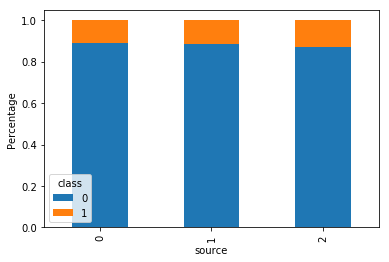

In [25]:
cab = pd.crosstab(data['source'], data['class'])
print(cab)
dummy = cab.div(cab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('source')
dummy = plt.ylabel('Percentage')

class      0     1
sex               
0      54687  7237
1      39014  4840


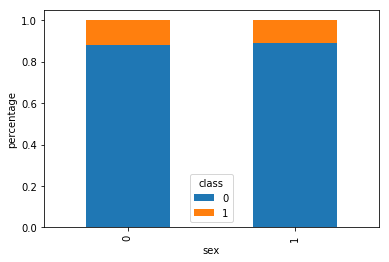

In [26]:
cab = pd.crosstab(data['sex'], data['class'])
print(cab)
dummy = cab.div(cab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('sex')
dummy = plt.ylabel('percentage')

class        0     1
browser             
0        37907  5242
1        22944  2679
2        15317  1879
3        15229  2002
4         2304   275


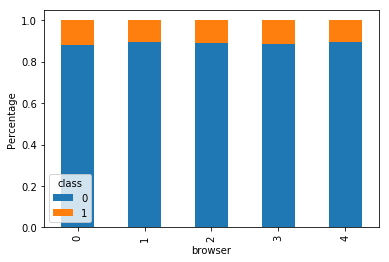

In [27]:
cab = pd.crosstab(data['browser'], data['class'])
print(cab)
dummy = cab.div(cab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('browser')
dummy = plt.ylabel('Percentage')

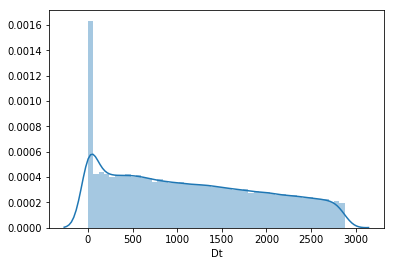

In [28]:
sns.distplot(data['Dt'])

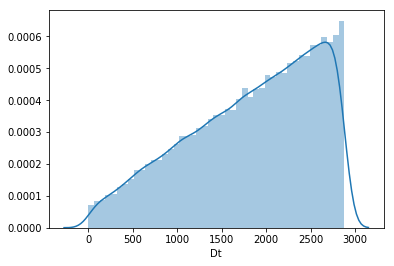

In [29]:
sns.distplot(test['Dt'])

In [30]:
print('Zeros in training sample: ', len(data[data['Dt']==0.0]))
print('Zeros in test sample: ', len(test[test['Dt']==0.0]))

Zeros in training sample:  7640
Zeros in test sample:  1


In [31]:
data0 = data[data['Dt']==0.0]
len(data0[data0['class']==1])/len(data0)

0.9952879581151832

#### At the begining of the year, there were 7640 events with Dt=0.0 and 99.53% of them were froud. However, there is only one such case in test sample (interestingly, this case is not fraud in test sample). Therefore, we will treat subsample as Dt=0.0 as anomaly and omit this cases in our analysis.

In [32]:
data = data.drop((data[data['Dt'] == 0.0]).index,0)

In [33]:
len(data)

98138

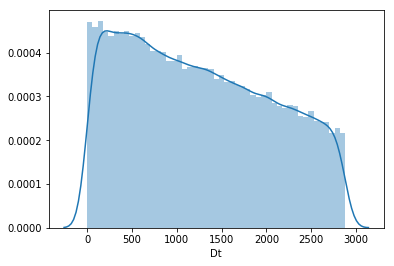

In [34]:
sns.distplot(data['Dt'])

In [35]:
print('Frauds in training sample:\n', len(data[data['class']==1])/len(data)*100, ' %')
print('Frauds in test sample:\n', len(test[test['class']==1])/len(test)*100, ' %')

Frauds in training sample:
 4.557867492714341  %
Frauds in test sample:
 4.574932721577624  %


Now, situation becomes almost the same in both training and test sample.

In [36]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
data = data.drop(['diff1','diff2'],axis=1)

In [37]:
data['occurence'] = 0

In [38]:
occur = data['device_id'].value_counts()

In [39]:
occur.head(10)

PTIOOOWLAKALH    3
HVGLMDIRYIEVX    3
ZAPVZMOKPESVX    3
VRLUJWUSZHOXO    3
JGTMORSPMAYBM    3
YLDDOCJIVHEJV    3
CGLAEGEJMRFXY    3
TUTIBAJWVRPPI    3
SHLDULVNSTDZB    3
LRZJOSJTQEHEX    3
Name: device_id, dtype: int64

### We want to make a new column in the table, which shows number of occurence for particular device_id.

In [40]:
data['occurence'] = data.apply(lambda row: occur[row['device_id']], axis=1)

In [41]:
data.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,Dt,occurence
378,58397,2015-01-01 03:04:18,2015-01-01 15:26:23,37,YICCDRLMZHPSM,1,2,0,30,3.686620e+09,0,1,12.0,1
713,326217,2015-01-01 13:53:34,2015-01-02 04:45:11,11,KBEAMBIXFHTQG,2,3,1,29,2.068289e+09,0,4,14.0,1
795,356114,2015-01-01 08:57:35,2015-01-02 08:15:12,36,VWFJUWSKZFWXK,0,0,0,46,4.121968e+09,0,0,23.0,1
846,64429,2015-01-01 13:04:16,2015-01-02 09:31:49,54,IAZPLBXKSKOGW,0,0,0,25,3.328207e+09,0,3,20.0,1
847,266142,2015-01-01 02:56:50,2015-01-02 09:42:20,33,VXPGOPOAJWYGS,0,0,0,32,4.943509e+08,0,2,30.0,1


In [42]:
data['occurence'].value_counts()

1    92796
2     5228
3      114
Name: occurence, dtype: int64

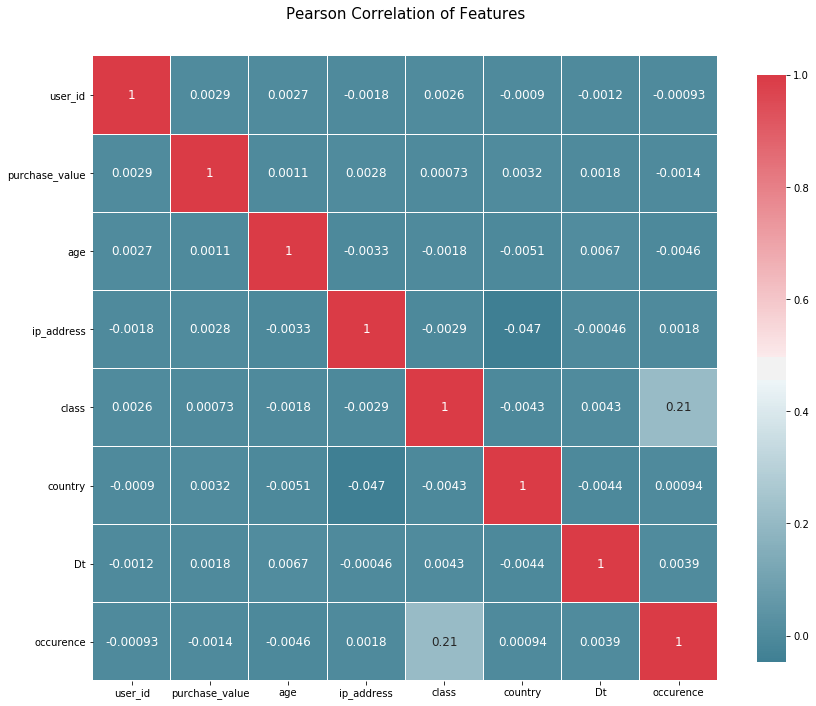

In [43]:
correlation_heatmap(data)

In [44]:
occur.head(10)

PTIOOOWLAKALH    3
HVGLMDIRYIEVX    3
ZAPVZMOKPESVX    3
VRLUJWUSZHOXO    3
JGTMORSPMAYBM    3
YLDDOCJIVHEJV    3
CGLAEGEJMRFXY    3
TUTIBAJWVRPPI    3
SHLDULVNSTDZB    3
LRZJOSJTQEHEX    3
Name: device_id, dtype: int64

In [45]:
data[data['device_id']== 'TUTIBAJWVRPPI']

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,Dt,occurence
19519,4715,2015-02-20 07:48:04,2015-03-09 20:24:39,90,TUTIBAJWVRPPI,1,0,0,39,2.708376e+09,0,35,420.0,3
21950,116289,2015-02-21 01:43:16,2015-03-16 05:23:39,26,TUTIBAJWVRPPI,0,0,0,22,8.437374e+08,0,2,555.0,3
78028,282927,2015-05-30 05:23:45,2015-06-22 08:44:06,65,TUTIBAJWVRPPI,0,0,0,41,1.685548e+09,0,0,555.0,3


class          0     1
occurence             
1          89541  3255
2           4032  1196
3             92    22


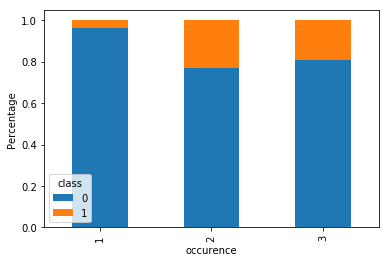

In [46]:
cab = pd.crosstab(data['occurence'], data['class'])
print(cab)
dummy = cab.div(cab.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True)
dummy = plt.xlabel('occurence')
dummy = plt.ylabel('Percentage')

### This is the only correlation observed up to now: if occurence > 1 probability for froud is more than 8 times higher. To additionaly prove this, we plot the folowing histrograms:

In [47]:
fraud = data[data['class']==1]
nofraud = data[data['class']==0]

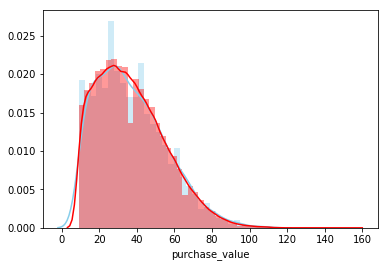

In [53]:
sns.distplot(fraud["purchase_value"] , color="skyblue", label="Fraud")
sns.distplot(nofraud["purchase_value"] , color="red", label="No Fraud")

The same distributions for **Purchase value**. Nothing interesting here.

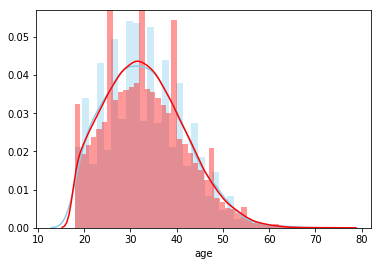

In [61]:
sns.distplot(fraud["age"] , color="skyblue", label="Fraud")
sns.distplot(nofraud["age"] , color="red", label="No Fraud")

The same distributions for **Age**. Nothing interesting here too.

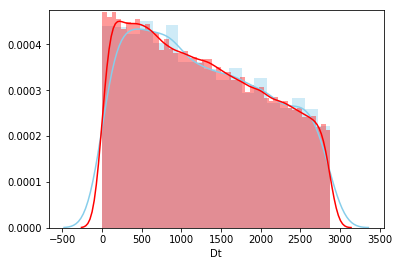

In [63]:
sns.distplot(fraud["Dt"] , color="skyblue", label="Fraud")
sns.distplot(nofraud["Dt"] , color="red", label="No Fraud")

The same distributions for **Dt**. Nothing interesting here too.

In [65]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98138 entries, 378 to 105777
Data columns (total 14 columns):
user_id           98138 non-null int64
signup_time       98138 non-null object
purchase_time     98138 non-null object
purchase_value    98138 non-null int64
device_id         98138 non-null object
source            98138 non-null object
browser           98138 non-null object
sex               98138 non-null object
age               98138 non-null int64
ip_address        98138 non-null float64
class             98138 non-null int64
country           98138 non-null int64
Dt                98138 non-null float64
occurence         98138 non-null int64
dtypes: float64(2), int64(6), object(6)
memory usage: 11.2+ MB


In [72]:
fraud['browser'] = fraud['browser'].astype(np.int64)
nofraud['browser'] = nofraud['browser'].astype(np.int64)

/home/marko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/marko/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


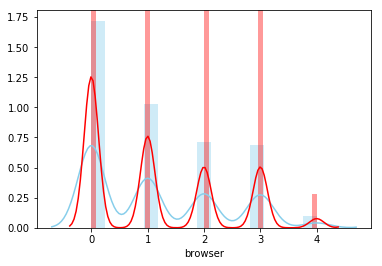

In [73]:
sns.distplot(fraud["browser"] , color="skyblue", label="Fraud")
sns.distplot(nofraud["browser"] , color="red", label="No Fraud")